# Purpose of this notebook

We need to quickly evaluate the performance of a logistic regression model on subsets of features to come up with the final reduced set of features. Complete the following steps:
1. standardize and automate logistic regression fitting and main metric calculation/plotting
2. compute and plot model performance with various regularization parameters
    * quick numerical output for comparison
    * graphical output for visual comparison

The datasets with different feature subsets are produced in the Feature_selection.ipynb notebook.
Once the final feature set is decided, fit multiple machine learning models in multiple_model_fitting.ipynb.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set a seed for reproducibility
SEED = 222
np.random.seed(SEED)

# import necessary sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [126]:
def logreg_fit(csv_file):
    """Fit a logistic regression model, compute confusion matrix and classification report.
    Plot ROC curve and precision-recall curve."""
    
    # import the csv file as a pandas DataFrame
    df = pd.read_csv('../data/processed/{}'.format(csv_file))
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # check if there are empty values
    assert df.isna().sum().sum()==0, 'There are missing values'
    
    # create numpy arrays with the explanatory variables and output label
    y = df.OUTPUT_LABEL.values
    X = df.drop(['OUTPUT_LABEL'], axis=1).values
    features = df.drop(['OUTPUT_LABEL'], axis=1).columns
    
    # split the data into train and test, scale all variables between 0 and 1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
    scaler = MinMaxScaler()
    Xtrain_scaled = scaler.fit_transform(Xtrain)
    Xtest_scaled = scaler.transform(Xtest)
    
    # start time counter, fit a logistic regression model, predict the output variable and estimate probabilities
    start_time = time.monotonic()
    clf = LogisticRegression(C=1, solver='liblinear', random_state=SEED, class_weight='balanced')
    clf.fit(Xtrain_scaled,ytrain)
    yscore = clf.predict(Xtest_scaled)
    ypred = clf.predict_proba(Xtest_scaled)[:,1]
    
    # compute the confusion matrix and classification report with model predicitons (yscore), print elappsed time
    print("File name:{}".format(csv_file))
    print("Confusion matrix")
    print(confusion_matrix(ytest, yscore))
    print("Classification report")
    print(classification_report(ytest, yscore))
    print("Time elapsed {}s".format(time.monotonic()-start_time))
    
    # compute ROC-AUC score (area under the curve), get FPR and TPR at corresponding thresholds and plot
    # receiver operating characteristic curve
    roc_auc = roc_auc_score(ytest, ypred)
    fpr, tpr, _ = roc_curve(ytest, ypred)
    fig, ax = plt.subplots(1, 2, figsize=(12,4))    
    ax[0].plot(fpr, tpr, label='Area = %0.3f' % roc_auc)
    ax[0].plot([0, 1], [0, 1],'r--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right")
    
    # compute average precision (AP, close to area under precision-recall curve), get precision and recall values
    # for corresponding thresholds and plot the precision-recall curve
    ave_prec_rec = average_precision_score(ytest, ypred)
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    ax[1].plot(recall, precision, label='AP = %0.3f' % ave_prec_rec)
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right")
    
    return clf, features, Xtrain_scaled, Xtest_scaled, ytrain, ytest
    
    start_time = time.monotonic()

File name:feat_select_fitting_030220.csv
Confusion matrix
[[4810 2299]
 [ 154  380]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80      7109
         1.0       0.14      0.71      0.24       534

    accuracy                           0.68      7643
   macro avg       0.56      0.69      0.52      7643
weighted avg       0.91      0.68      0.76      7643

Time elapsed 2.0155424200056586s


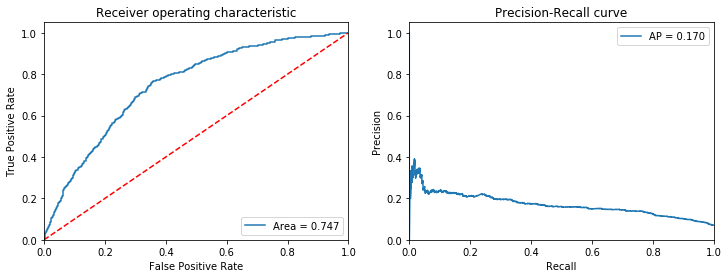

In [127]:
# the dataset without feature selection, 314 features
csv_file = 'feat_select_fitting_030220.csv'
clf, features, Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [128]:
def score_models(P, y):
    """Calculate AUROC and AP for each probability estimate in array P, given ground truth y"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        ap = average_precision_score(y, P.loc[:, m])
        print("%-26s: %.3f, %.3f" % (m, score, ap))
    print("Done.\n")

def test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled):
    """Fit a logistic regression model with different C regularization coefficients
    and compute AUROC and AP for each model"""
    Cs = np.logspace(-4, 4, 9)
    # allocate an array of zeros to store probability estimates for each model
    PL = np.zeros((ytest.shape[0], len(Cs)))
    PL = pd.DataFrame(PL)
    PL.columns = Cs

    logreg_models = {} # create a dictionary of models
    for i in range(len(Cs)):
        clf = LogisticRegression(C=Cs[i], random_state=SEED, solver='liblinear', class_weight='balanced')
        clf.fit(Xtrain_scaled, ytrain)
        PL.iloc[:, i] = clf.predict_proba(Xtest_scaled)[:, 1] # store probability estimate in the ith column
        logreg_models[Cs[i]] = clf # save the classifier as value with the C as key in the models dictionary

    # print AUC and AP scores
    score_models(PL, ytest) 
    
    return PL, logreg_models

In [132]:
PL, logreg_models = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.683, 0.144
0.001                     : 0.700, 0.153
0.01                      : 0.729, 0.165
0.1                       : 0.745, 0.168
1.0                       : 0.747, 0.170
10.0                      : 0.746, 0.170
100.0                     : 0.746, 0.170
1000.0                    : 0.746, 0.170
10000.0                   : 0.746, 0.170
Done.



In [133]:
PL.head()

,0.0001,0.0010,0.0100,0.1000,1.0000,10.0000,100.0000,1000.0000,10000.0000
0,0.492090,0.443319,0.381907,0.319062,0.279687,0.271171,0.272154,0.276103,0.281731
1,0.569999,0.750291,0.880249,0.924997,0.921578,0.913825,0.919001,0.923178,0.923959
2,0.483190,0.396765,0.255211,0.192244,0.241937,0.261825,0.266327,0.268267,0.270363
3,0.554189,0.689545,0.763910,0.794493,0.841150,0.863723,0.864042,0.859751,0.858228
4,0.465530,0.361981,0.356050,0.324983,0.238229,0.220852,0.223287,0.225476,0.225542


In [134]:
logreg_models[0.1]

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=222, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [135]:
def plot_roc_pr(PL, ytest):
    """Plot ROC and precision-recall curves for each model"""
    fig, ax = plt.subplots(1, 2, figsize=(12,4))    

    for column in PL.columns:
        roc_auc = roc_auc_score(ytest, PL[column])
        fpr, tpr, _ = roc_curve(ytest, PL[column])
        ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

        precision, recall, _ = precision_recall_curve(ytest, PL[column])
        ave_prec_rec = average_precision_score(ytest, PL[column])
        ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="C: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="C: AP")

    plt.savefig('../reports/figures/roc_pr_'+csv_file+'.png')

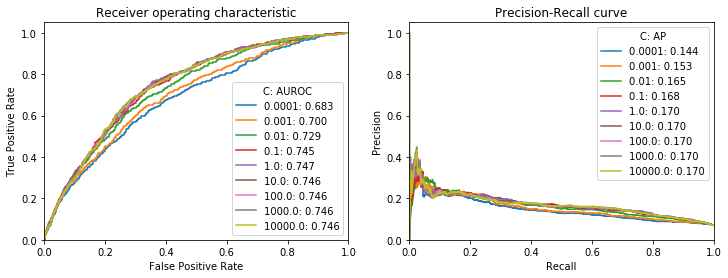

In [136]:
plot_roc_pr(PL, ytest)

In [137]:
coefficients = np.squeeze(clf.coef_).T.tolist()
coef_df = pd.DataFrame({'feature':features, 'coefficient':coefficients})
coef_df.sort_values(by='coefficient', ascending=False, inplace=True)
print(coef_df.head(10))
print(coef_df.tail(10))

                                         feature  coefficient
13    DISCHARGE_LOCATION_LONG TERM CARE HOSPITAL     3.109059
12  DISCHARGE_LOCATION_LEFT AGAINST MEDICAL ADVI     2.936305
53                    SUBSECTIONHEADER_Pulmonary     2.925831
16                        DISCHARGE_LOCATION_SNF     2.904170
14   DISCHARGE_LOCATION_REHAB/DISTINCT PART HOSP     2.895123
10           DISCHARGE_LOCATION_HOME HEALTH CARE     2.611045
9                        DISCHARGE_LOCATION_HOME     2.334187
8    DISCHARGE_LOCATION_DISCH-TRAN TO PSYCH HOSP     2.031605
15        DISCHARGE_LOCATION_SHORT TERM HOSPITAL     1.967292
70                               Count_Magnesium     1.874983
                                     feature  coefficient
37   SUBSECTIONHEADER_Critical care services    -1.207282
151                                   cathet    -1.382375
122                                  Var_RDW    -1.407087
28                        CURR_SERVICE_ORTHO    -1.438910
51       SUBSECTIONHEADER_Pr

File name:df_0.005_0.005.csv
Confusion matrix
[[4897 2212]
 [ 213  321]]
Classification report
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80      7109
         1.0       0.13      0.60      0.21       534

    accuracy                           0.68      7643
   macro avg       0.54      0.64      0.51      7643
weighted avg       0.90      0.68      0.76      7643

Time elapsed 1.1162318410060834s


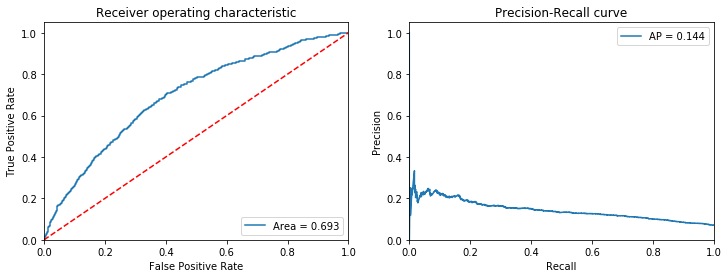

In [138]:
# csv file eliminating features with correlation ratio < 0.005, Theil's U < 0.005
csv_file = 'df_0.005_0.005.csv'
clf, features, Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [139]:
PL, logreg_models = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.681, 0.142
0.001                     : 0.684, 0.144
0.01                      : 0.689, 0.143
0.1                       : 0.691, 0.141
1.0                       : 0.693, 0.144
10.0                      : 0.694, 0.143
100.0                     : 0.694, 0.142
1000.0                    : 0.694, 0.142
10000.0                   : 0.694, 0.142
Done.



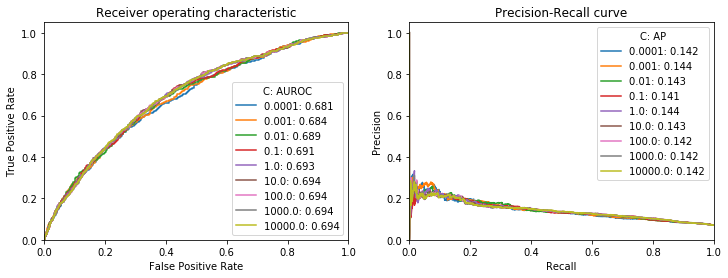

In [21]:
plot_roc_pr(PL, ytest)

In [20]:
coefficients = np.squeeze(clf.coef_).T.tolist()
coef_df = pd.DataFrame({'feature':features, 'coefficient':coefficients})
coef_df.sort_values(by='coefficient', ascending=False, inplace=True)
print(coef_df.head(10))
print(coef_df.tail(10))

                                         feature  coefficient
28                               Count_Potassium     8.886785
22                                     Count_MCV     7.808246
15                              Count_Creatinine     7.349442
13                          Count_Calcium, Total     6.094236
24                                      Count_PT     5.390440
29                                     Count_RDW     4.408837
40                               Mean_Hematocrit     4.156714
35                              Mean_Bicarbonate     3.233520
8   SUBSECTIONHEADER_Hospital inpatient services     3.184631
16                                 Count_Glucose     2.856294
                 feature  coefficient
32   Count_Urea Nitrogen    -4.318502
43              Mean_MCH    -4.611648
19         Count_INR(PT)    -5.084475
51  Mean_Red Blood Cells    -7.290895
56    Var_Calcium, Total    -7.385758
26       Count_Phosphate    -7.658779
21            Count_MCHC    -8.019960
31          Co

File name:df_0.0025_0.0025.csv
Confusion matrix
[[4784 2325]
 [ 183  351]]
Classification report
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79      7109
         1.0       0.13      0.66      0.22       534

    accuracy                           0.67      7643
   macro avg       0.55      0.67      0.51      7643
weighted avg       0.91      0.67      0.75      7643

Time elapsed 1.9816218630003277s


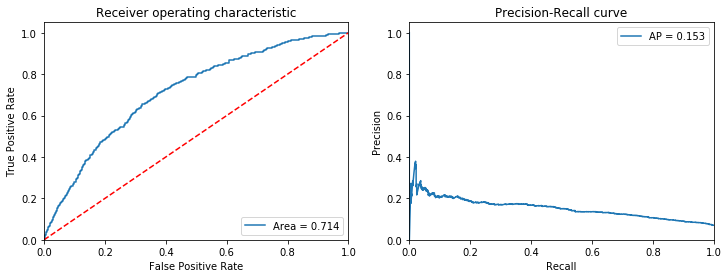

In [140]:
# csv file eliminating features with correlation ratio < 0.0025, Theil's U < 0.0025
csv_file = 'df_0.0025_0.0025.csv'
clf, features, Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [141]:
PL, logreg_models = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.684, 0.142
0.001                     : 0.695, 0.147
0.01                      : 0.709, 0.150
0.1                       : 0.713, 0.150
1.0                       : 0.714, 0.153
10.0                      : 0.715, 0.153
100.0                     : 0.715, 0.152
1000.0                    : 0.715, 0.151
10000.0                   : 0.715, 0.151
Done.



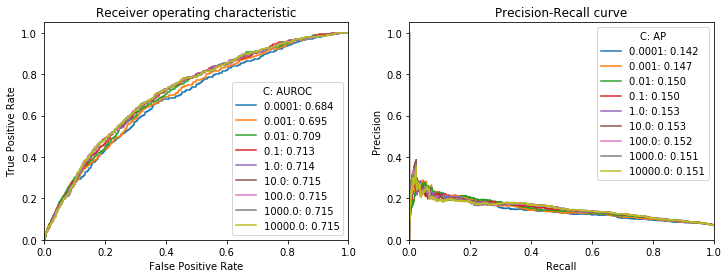

In [24]:
plot_roc_pr(PL, ytest)

In [22]:
coefficients = np.squeeze(clf.coef_).T.tolist()
coef_df = pd.DataFrame({'feature':features, 'coefficient':coefficients})
coef_df.sort_values(by='coefficient', ascending=False, inplace=True)
print(coef_df.head(10))
print(coef_df.tail(10))

                                          feature  coefficient
36                                Count_Potassium     9.096422
30                                      Count_MCV     7.743795
23                               Count_Creatinine     6.516843
15   SUBSECTIONHEADER_Hospital inpatient services     5.642599
21                           Count_Calcium, Total     5.241449
32                                       Count_PT     4.819560
48                                Mean_Hematocrit     4.465079
16                     SUBSECTIONHEADER_Pulmonary     3.519187
129                                      malfunct     3.441512
43                               Mean_Bicarbonate     3.338393
                  feature  coefficient
34        Count_Phosphate    -5.318827
65     Var_Calcium, Total    -5.650417
70            Var_INR(PT)    -6.122782
35   Count_Platelet Count    -6.750942
149              reaction    -7.053539
29             Count_MCHC    -7.668961
69         Var_Hemoglobin    -8.12

File name:df_0.001_0.001.csv
Confusion matrix
[[4816 2293]
 [ 186  348]]
Classification report
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80      7109
         1.0       0.13      0.65      0.22       534

    accuracy                           0.68      7643
   macro avg       0.55      0.66      0.51      7643
weighted avg       0.90      0.68      0.76      7643

Time elapsed 1.8802528879896272s


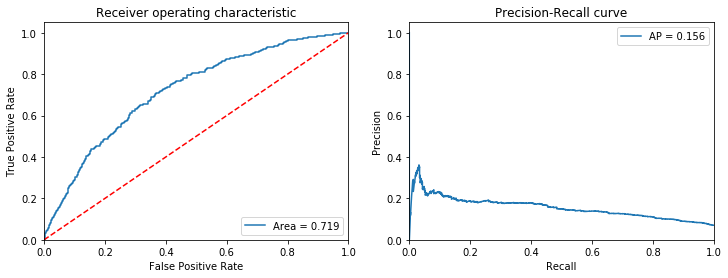

In [142]:
# csv file eliminating features with correlation ratio < 0.001, Theil's U < 0.001
csv_file = 'df_0.001_0.001.csv'
clf, features, Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [143]:
PL, logreg_models = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.683, 0.143
0.001                     : 0.696, 0.148
0.01                      : 0.712, 0.153
0.1                       : 0.717, 0.154
1.0                       : 0.719, 0.156
10.0                      : 0.720, 0.155
100.0                     : 0.720, 0.154
1000.0                    : 0.720, 0.154
10000.0                   : 0.720, 0.154
Done.



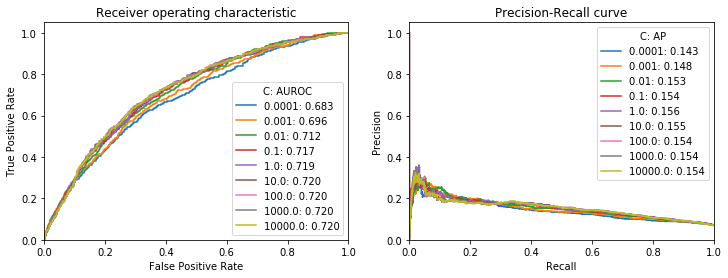

In [27]:
plot_roc_pr(PL, ytest)

In [24]:
coefficients = np.squeeze(clf.coef_).T.tolist()
coef_df = pd.DataFrame({'feature':features, 'coefficient':coefficients})
coef_df.sort_values(by='coefficient', ascending=False, inplace=True)
print(coef_df.head(10))
print(coef_df.tail(10))

                  feature  coefficient
44        Count_Potassium     8.663015
38              Count_MCV     7.849598
230                stupor     7.314526
29   Count_Calcium, Total     5.692131
82                Var_MCV     5.673088
31       Count_Creatinine     5.610773
40               Count_PT     5.023166
160                 hepat     4.987831
56        Mean_Hematocrit     4.316302
164                    hr     4.091066
                  feature  coefficient
37             Count_MCHC    -7.293813
122                  coma    -7.845392
79         Var_Hemoglobin    -8.028379
69   Mean_Red Blood Cells    -8.282148
43   Count_Platelet Count    -8.606077
76         Var_Creatinine    -9.516379
47           Count_Sodium   -10.218291
84                 Var_PT   -14.045755
90    Var_Red Blood Cells   -14.605531
81                Var_MCH   -15.701738


File name:df_0.0005_0.0005.csv
Confusion matrix
[[4815 2294]
 [ 186  348]]
Classification report
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80      7109
         1.0       0.13      0.65      0.22       534

    accuracy                           0.68      7643
   macro avg       0.55      0.66      0.51      7643
weighted avg       0.90      0.68      0.75      7643

Time elapsed 1.751707877003355s


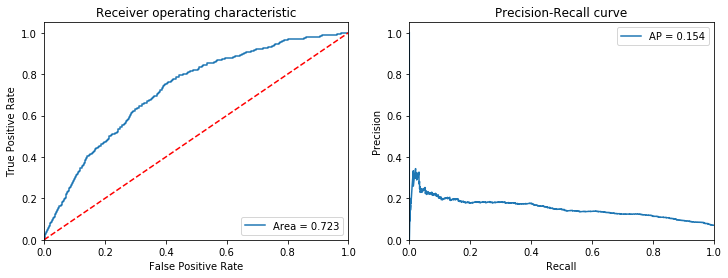

In [145]:
# csv file eliminating features with correlation ratio < 0.0005, Theil's U < 0.0005
csv_file = 'df_0.0005_0.0005.csv'
clf, features, Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [146]:
PL, logreg_models = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.684, 0.143
0.001                     : 0.697, 0.149
0.01                      : 0.715, 0.154
0.1                       : 0.722, 0.154
1.0                       : 0.723, 0.154
10.0                      : 0.723, 0.153
100.0                     : 0.723, 0.153
1000.0                    : 0.724, 0.153
10000.0                   : 0.724, 0.153
Done.



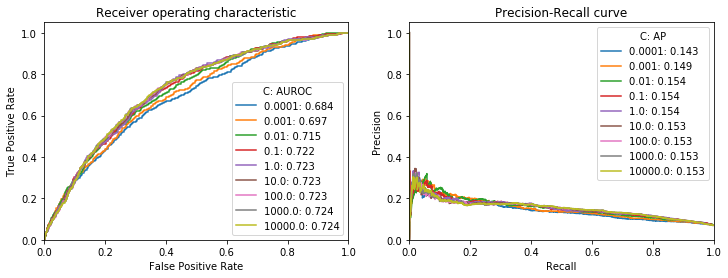

In [30]:
plot_roc_pr(PL, ytest)

## Filtering out features based on correlation ratio and Theil's U is not fruitful, as even at smallest thresholds of 0.0005 for each coefficient, both the AUROC and AP go down. Next, try filtering redundant rows based in Pearson correlation and Cramer's V coefficients.

File name:df_p09.csv
Confusion matrix
[[4795 2314]
 [ 155  379]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.80      7109
         1.0       0.14      0.71      0.23       534

    accuracy                           0.68      7643
   macro avg       0.55      0.69      0.52      7643
weighted avg       0.91      0.68      0.76      7643

Time elapsed 1.3138266289897729s


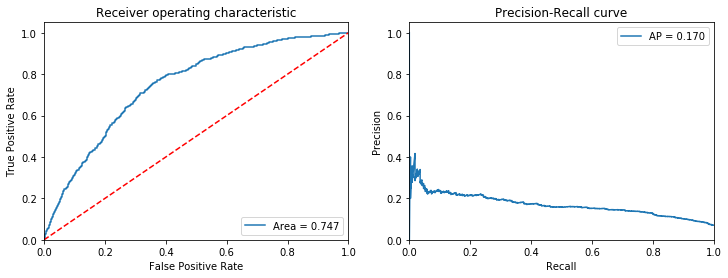

In [147]:
# dataset with redundant numerical features eliminated, pearson correlation coefficient >= 0.9
csv_file = 'df_p09.csv'
clf, features, Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [148]:
PL, logreg_models = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.682, 0.142
0.001                     : 0.700, 0.152
0.01                      : 0.729, 0.164
0.1                       : 0.745, 0.168
1.0                       : 0.747, 0.170
10.0                      : 0.747, 0.170
100.0                     : 0.747, 0.170
1000.0                    : 0.747, 0.169
10000.0                   : 0.747, 0.169
Done.



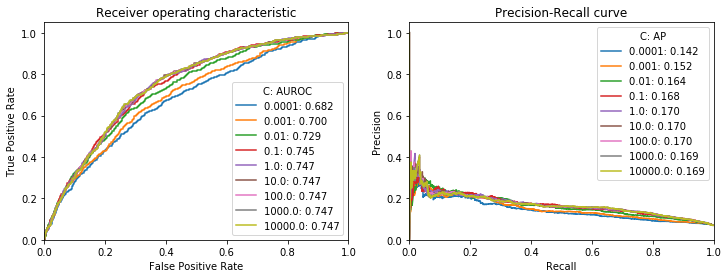

In [33]:
plot_roc_pr(PL, ytest)

In [52]:
coefficients = np.squeeze(clf.coef_).T.tolist()
coef_df = pd.DataFrame({'feature':features, 'coefficient':coefficients})
coef_df.sort_values(by='coefficient', ascending=False, inplace=True)
print(coef_df.head(10))
print(coef_df.tail(10))

                                          feature  coefficient
53                     SUBSECTIONHEADER_Pulmonary     3.249142
13     DISCHARGE_LOCATION_LONG TERM CARE HOSPITAL     3.110775
12   DISCHARGE_LOCATION_LEFT AGAINST MEDICAL ADVI     2.938732
16                         DISCHARGE_LOCATION_SNF     2.904241
14    DISCHARGE_LOCATION_REHAB/DISTINCT PART HOSP     2.897973
10            DISCHARGE_LOCATION_HOME HEALTH CARE     2.611339
9                         DISCHARGE_LOCATION_HOME     2.336041
8     DISCHARGE_LOCATION_DISCH-TRAN TO PSYCH HOSP     2.028762
15         DISCHARGE_LOCATION_SHORT TERM HOSPITAL     1.970237
132                                        cerebr     1.798098
                                     feature  coefficient
60                            Mean_Anion Gap    -1.146675
37   SUBSECTIONHEADER_Critical care services    -1.264884
99                                   Var_RDW    -1.360559
128                                   cathet    -1.396044
28               

File name:df_p09_sorted.csv
Confusion matrix
[[4788 2321]
 [ 155  379]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79      7109
         1.0       0.14      0.71      0.23       534

    accuracy                           0.68      7643
   macro avg       0.55      0.69      0.51      7643
weighted avg       0.91      0.68      0.76      7643

Time elapsed 1.431499755999539s


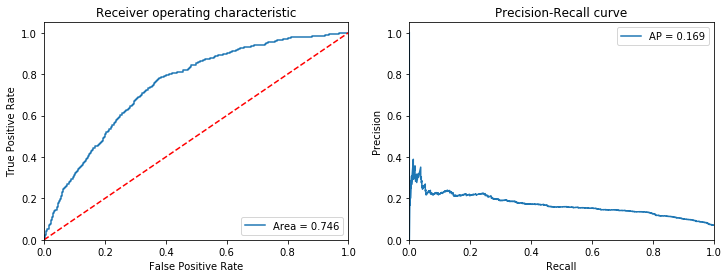

In [149]:
# in this dataset features were sorted by decreasing correlation ratio before applying the Pearson correlation 
# filter of >=0.9. Hence the remaining features should have greater correlation ratio than eliminated ones
csv_file = 'df_p09_sorted.csv'
clf, features, Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [150]:
PL, logreg_models = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.682, 0.142
0.001                     : 0.699, 0.152
0.01                      : 0.729, 0.164
0.1                       : 0.745, 0.169
1.0                       : 0.746, 0.169
10.0                      : 0.746, 0.169
100.0                     : 0.746, 0.168
1000.0                    : 0.746, 0.168
10000.0                   : 0.746, 0.168
Done.



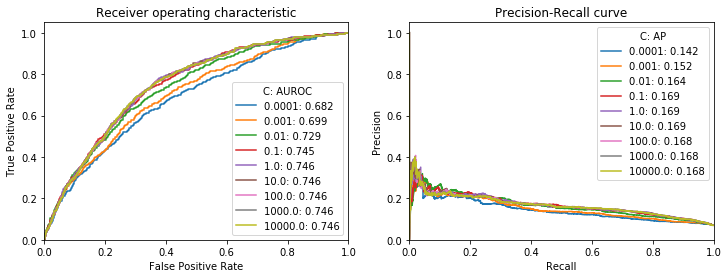

In [43]:
plot_roc_pr(PL, ytest)

In [54]:
coefficients = np.squeeze(clf.coef_).T.tolist()
coef_df = pd.DataFrame({'feature':features, 'coefficient':coefficients})
coef_df.sort_values(by='coefficient', ascending=False, inplace=True)
print(coef_df.head(10))
print(coef_df.tail(10))

                                          feature  coefficient
12     DISCHARGE_LOCATION_LONG TERM CARE HOSPITAL     3.084425
11   DISCHARGE_LOCATION_LEFT AGAINST MEDICAL ADVI     2.919231
15                         DISCHARGE_LOCATION_SNF     2.865097
13    DISCHARGE_LOCATION_REHAB/DISTINCT PART HOSP     2.849317
52                     SUBSECTIONHEADER_Pulmonary     2.738515
9             DISCHARGE_LOCATION_HOME HEALTH CARE     2.580394
8                         DISCHARGE_LOCATION_HOME     2.320890
7     DISCHARGE_LOCATION_DISCH-TRAN TO PSYCH HOSP     2.021979
14         DISCHARGE_LOCATION_SHORT TERM HOSPITAL     1.952869
131                                        cerebr     1.853974
                                               feature  coefficient
85                                      Var_Creatinine    -1.084993
48   SUBSECTIONHEADER_Operating microscope (deleted...    -1.108242
265                                              stent    -1.133380
127                                

File name:df_p09_cv09.csv
Confusion matrix
[[4783 2326]
 [ 169  365]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79      7109
         1.0       0.14      0.68      0.23       534

    accuracy                           0.67      7643
   macro avg       0.55      0.68      0.51      7643
weighted avg       0.91      0.67      0.75      7643

Time elapsed 1.306337646994507s


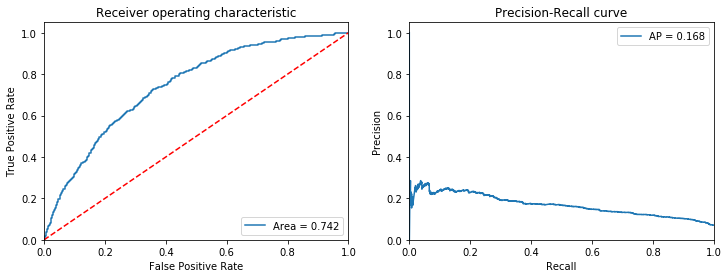

In [151]:
# first the numerical features with Pearson correlation coefficient >=0.9 were eliminated, then categorical 
# features with Cramer's V >=0.9
csv_file = 'df_p09_cv09.csv'
clf, features, Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [73]:
coefficients = np.squeeze(clf.coef_).T.tolist()
coef_df = pd.DataFrame({'feature':features, 'coefficient':coefficients})
coef_df.sort_values(by='coefficient', ascending=False, inplace=True)
print(coef_df.head(20))
print(coef_df.tail(20))

                                              feature  coefficient
53                         SUBSECTIONHEADER_Pulmonary     3.595923
13         DISCHARGE_LOCATION_LONG TERM CARE HOSPITAL     3.056701
12       DISCHARGE_LOCATION_LEFT AGAINST MEDICAL ADVI     2.933920
16                             DISCHARGE_LOCATION_SNF     2.855738
14        DISCHARGE_LOCATION_REHAB/DISTINCT PART HOSP     2.844205
10                DISCHARGE_LOCATION_HOME HEALTH CARE     2.578429
9                             DISCHARGE_LOCATION_HOME     2.290330
15             DISCHARGE_LOCATION_SHORT TERM HOSPITAL     1.962240
8         DISCHARGE_LOCATION_DISCH-TRAN TO PSYCH HOSP     1.961824
77                                           Mean_RDW     1.614285
57                             SUBSECTIONHEADER_TOTAL     1.470097
66                                    Mean_Hematocrit     1.263016
81                             Mean_White Blood Cells     1.238317
65                                       Mean_Glucose     1.22

File name:df_p09_sorted_cv09.csv
Confusion matrix
[[4772 2337]
 [ 172  362]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79      7109
         1.0       0.13      0.68      0.22       534

    accuracy                           0.67      7643
   macro avg       0.55      0.67      0.51      7643
weighted avg       0.91      0.67      0.75      7643

Time elapsed 1.6864832050050609s


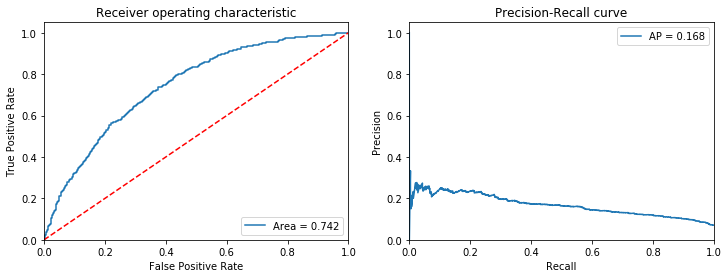

In [152]:
# in this dataset features were sorted by decreasing correlation ratio before applying the Pearson correlation 
# filter of >=0.9. Hence the remaining features should have greater correlation ratio than eliminated ones. 
# Next features with Cramer's v >=0.9 were eliminated.
csv_file = 'df_p09_sorted_cv09.csv'
clf, features, Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [75]:
coefficients = np.squeeze(clf.coef_).T.tolist()
coef_df = pd.DataFrame({'feature':features, 'coefficient':coefficients})
coef_df.sort_values(by='coefficient', ascending=False, inplace=True)
print(coef_df.head(20))
print(coef_df.tail(20))

                                               feature  coefficient
52                          SUBSECTIONHEADER_Pulmonary     3.040469
12          DISCHARGE_LOCATION_LONG TERM CARE HOSPITAL     3.031753
11        DISCHARGE_LOCATION_LEFT AGAINST MEDICAL ADVI     2.912923
15                              DISCHARGE_LOCATION_SNF     2.815967
13         DISCHARGE_LOCATION_REHAB/DISTINCT PART HOSP     2.792800
9                  DISCHARGE_LOCATION_HOME HEALTH CARE     2.548314
8                              DISCHARGE_LOCATION_HOME     2.277369
7          DISCHARGE_LOCATION_DISCH-TRAN TO PSYCH HOSP     1.957984
14              DISCHARGE_LOCATION_SHORT TERM HOSPITAL     1.948974
76                                            Mean_RDW     1.573584
80                              Mean_White Blood Cells     1.297965
53                 SUBSECTIONHEADER_Respiratory system     1.297778
64                                        Mean_Glucose     1.238600
10                     DISCHARGE_LOCATION_HOSPIC

File name:df_p09_sorted_cv09_sorted.csv
Confusion matrix
[[4803 2306]
 [ 170  364]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80      7109
         1.0       0.14      0.68      0.23       534

    accuracy                           0.68      7643
   macro avg       0.55      0.68      0.51      7643
weighted avg       0.91      0.68      0.76      7643

Time elapsed 1.4436970879905857s


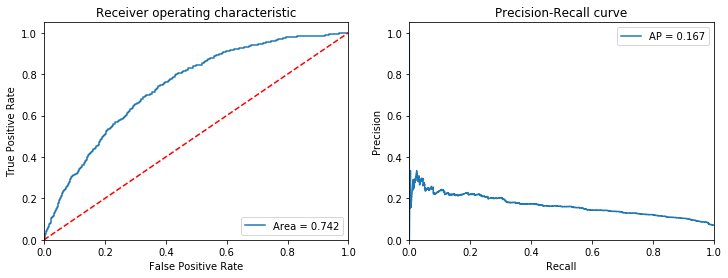

In [161]:
# in this dataset both numerical and categorical features were sorted in descending order by correlation ratio and
# Theil's U respectively. Next numerical features with Pearson correlation coefficient >0.9 and categorical features
# with Cramer's V >= 0.9 were eliminated. Hence, the remianing features should have higher correlation ratio (numerical)
# Theil's U (categorical) values than the eliminated ones.
csv_file = 'df_p09_sorted_cv09_sorted.csv'
clf, features, Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [162]:
PL, logreg_models = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.677, 0.139
0.001                     : 0.696, 0.148
0.01                      : 0.727, 0.162
0.1                       : 0.741, 0.166
1.0                       : 0.742, 0.167
10.0                      : 0.742, 0.167
100.0                     : 0.742, 0.167
1000.0                    : 0.742, 0.166
10000.0                   : 0.742, 0.166
Done.



## Although by a smaller differnce in AUROC and AP the dataset with unsorted numerical feature elimination (Pearson coef. >=0.9) and sorted categorical feature elimination (Theil's U descending order, Cramer's V >=0.9) is the best porforming one. I picked this dataset (feature set for the final analysis).

File name:df_p09_cv09_sorted.csv
Confusion matrix
[[4804 2305]
 [ 166  368]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80      7109
         1.0       0.14      0.69      0.23       534

    accuracy                           0.68      7643
   macro avg       0.55      0.68      0.51      7643
weighted avg       0.91      0.68      0.76      7643

Time elapsed 1.7615777759929188s


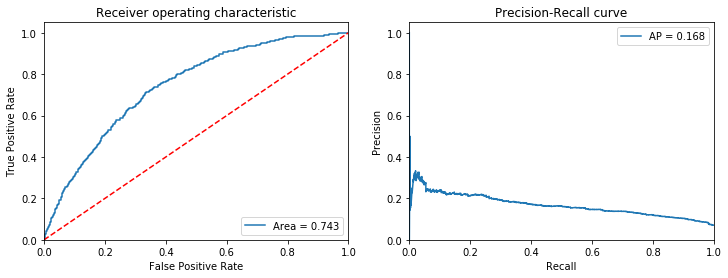

In [153]:
# first the numerical features with Pearson correlation coefficient >=0.9 were eliminated. Next, categorical 
# features sorted by decreasing Theil's U coefficient and then features with Cramer's V >=0.9 eliminated. Hence 
# remaining categrical features have greater Theil's U coefficnet than eliminated ones.
csv_file = 'df_p09_cv09_sorted.csv'
clf, features, Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [121]:
coefficients = np.squeeze(clf.coef_).T.tolist()
coef_df = pd.DataFrame({'feature':features, 'coefficient':coefficients})
coef_df.sort_values(by='coefficient', ascending=False, inplace=True)
print(coef_df.head(30))

                                               feature  coefficient
53                          SUBSECTIONHEADER_Pulmonary     3.532221
13          DISCHARGE_LOCATION_LONG TERM CARE HOSPITAL     3.052530
12        DISCHARGE_LOCATION_LEFT AGAINST MEDICAL ADVI     2.894396
14         DISCHARGE_LOCATION_REHAB/DISTINCT PART HOSP     2.838508
16                              DISCHARGE_LOCATION_SNF     2.830531
10                 DISCHARGE_LOCATION_HOME HEALTH CARE     2.554723
9                              DISCHARGE_LOCATION_HOME     2.264512
15              DISCHARGE_LOCATION_SHORT TERM HOSPITAL     1.921868
8          DISCHARGE_LOCATION_DISCH-TRAN TO PSYCH HOSP     1.899075
77                                            Mean_RDW     1.575423
57                              SUBSECTIONHEADER_TOTAL     1.483992
50   SUBSECTIONHEADER_Physical medicine and rehabil...     1.420191
66                                     Mean_Hematocrit     1.394244
59                                       Count_I

In [111]:
clf.get_params()

{'C': 1,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 222,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [77]:
Xtrain_scaled.shape

(30568, 188)

In [154]:
PL, logreg_models = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.677, 0.139
0.001                     : 0.696, 0.148
0.01                      : 0.727, 0.162
0.1                       : 0.741, 0.166
1.0                       : 0.743, 0.168
10.0                      : 0.743, 0.168
100.0                     : 0.743, 0.168
1000.0                    : 0.744, 0.168
10000.0                   : 0.744, 0.168
Done.



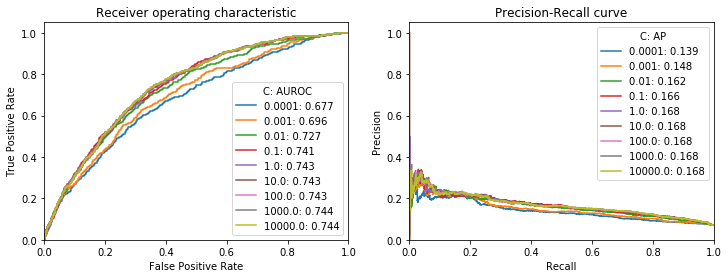

In [102]:
plot_roc_pr(PL, ytest)

Confusion matrix
[[4804 2305]
 [ 166  368]]
Normalized confusion matrix
[[0.68 0.32]
 [0.31 0.69]]


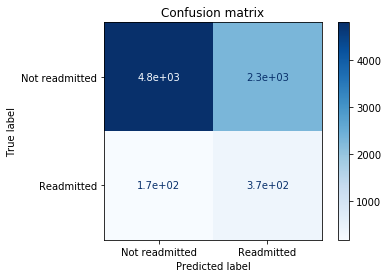

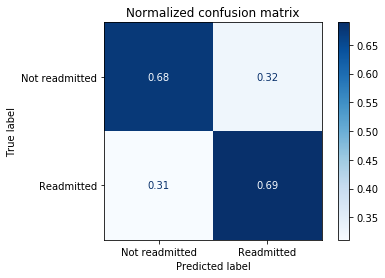

In [103]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['Not readmitted', 'Readmitted']

np.set_printoptions(precision=2)

titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, Xtest_scaled, ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    plt.savefig('../reports/figures/{}_conf_matrix.png'.format(title), format='png')

plt.show()

### Try recursive feature elimination on the best dataset so far, to see if the futures can be further eliminated without AUROC or AP loss.

In [157]:
start_time = time.monotonic()
from sklearn.feature_selection import RFE
selector = RFE(clf, 120, step=0.1)
selector = selector.fit(Xtrain_scaled, ytrain)
Xtest_scaled_reduced = selector.transform(Xtest_scaled)
yscore = selector.estimator_.predict(Xtest_scaled_reduced)
print("Confusion matrix")
print(confusion_matrix(ytest, yscore))
print("Classification report")
print(classification_report(ytest, yscore))
print(time.monotonic()-start_time)

Confusion matrix
[[4797 2312]
 [ 160  374]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.80      7109
         1.0       0.14      0.70      0.23       534

    accuracy                           0.68      7643
   macro avg       0.55      0.69      0.51      7643
weighted avg       0.91      0.68      0.76      7643

5.82367209700169


In [158]:
Xtrain_scaled_reduced = selector.transform(Xtrain_scaled)
PL, logreg_models = test_c_vals(Xtrain_scaled_reduced, ytrain, Xtest_scaled_reduced)

Scoring models.
0.0001                    : 0.682, 0.140
0.001                     : 0.693, 0.143
0.01                      : 0.723, 0.156
0.1                       : 0.740, 0.161
1.0                       : 0.743, 0.164
10.0                      : 0.744, 0.165
100.0                     : 0.744, 0.165
1000.0                    : 0.744, 0.165
10000.0                   : 0.744, 0.165
Done.



In [159]:
start_time = time.monotonic()
from sklearn.feature_selection import RFE
selector = RFE(clf, 140, step=0.1)
selector = selector.fit(Xtrain_scaled, ytrain)
Xtest_scaled_reduced = selector.transform(Xtest_scaled)
yscore = selector.estimator_.predict(Xtest_scaled_reduced)
print("Confusion matrix")
print(confusion_matrix(ytest, yscore))
print("Classification report")
print(classification_report(ytest, yscore))
print(time.monotonic()-start_time)
Xtrain_scaled_reduced = selector.transform(Xtrain_scaled)
PL, logreg_models = test_c_vals(Xtrain_scaled_reduced, ytrain, Xtest_scaled_reduced)

Confusion matrix
[[4782 2327]
 [ 162  372]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79      7109
         1.0       0.14      0.70      0.23       534

    accuracy                           0.67      7643
   macro avg       0.55      0.68      0.51      7643
weighted avg       0.91      0.67      0.75      7643

5.020405370014487
Scoring models.
0.0001                    : 0.682, 0.138
0.001                     : 0.694, 0.143
0.01                      : 0.725, 0.157
0.1                       : 0.741, 0.161
1.0                       : 0.742, 0.164
10.0                      : 0.742, 0.164
100.0                     : 0.742, 0.164
1000.0                    : 0.742, 0.164
10000.0                   : 0.742, 0.164
Done.



In [160]:
start_time = time.monotonic()
from sklearn.feature_selection import RFE
selector = RFE(clf, 160, step=0.1)
selector = selector.fit(Xtrain_scaled, ytrain)
Xtest_scaled_reduced = selector.transform(Xtest_scaled)
yscore = selector.estimator_.predict(Xtest_scaled_reduced)
print("Confusion matrix")
print(confusion_matrix(ytest, yscore))
print("Classification report")
print(classification_report(ytest, yscore))
print(time.monotonic()-start_time)
Xtrain_scaled_reduced = selector.transform(Xtrain_scaled)
PL, logreg_models = test_c_vals(Xtrain_scaled_reduced, ytrain, Xtest_scaled_reduced)

Confusion matrix
[[4797 2312]
 [ 169  365]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79      7109
         1.0       0.14      0.68      0.23       534

    accuracy                           0.68      7643
   macro avg       0.55      0.68      0.51      7643
weighted avg       0.91      0.68      0.75      7643

4.815106228023069
Scoring models.
0.0001                    : 0.681, 0.141
0.001                     : 0.695, 0.147
0.01                      : 0.726, 0.159
0.1                       : 0.740, 0.164
1.0                       : 0.742, 0.166
10.0                      : 0.741, 0.166
100.0                     : 0.742, 0.166
1000.0                    : 0.742, 0.166
10000.0                   : 0.742, 0.166
Done.



### Average precision is lower when features are recursively eliminated to a final number of either 120, 140, or 160. Hence, do not pursue this approach.

File name:df_p09_cv095_sorted.csv
Confusion matrix
[[4775 2334]
 [ 158  376]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79      7109
         1.0       0.14      0.70      0.23       534

    accuracy                           0.67      7643
   macro avg       0.55      0.69      0.51      7643
weighted avg       0.91      0.67      0.75      7643

Time elapsed 1.3918938639981207s


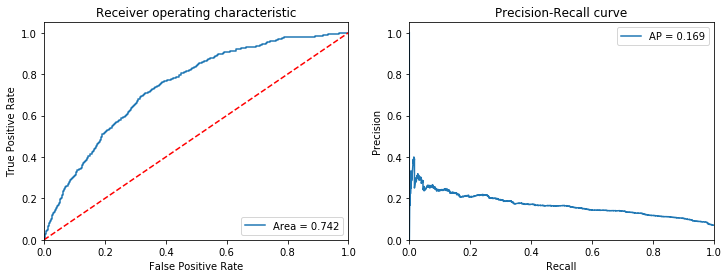

In [163]:
# would eliminating less categorical features help? In this dataset eliminated numerical features with Pearson 
# correlation coefficient >=0.9 and categorical features with Cramer's V >= 0.95.
csv_file = 'df_p09_cv095_sorted.csv'
clf, features, Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [164]:
PL, logreg_models = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.677, 0.140
0.001                     : 0.696, 0.149
0.01                      : 0.727, 0.163
0.1                       : 0.741, 0.168
1.0                       : 0.742, 0.169
10.0                      : 0.742, 0.169
100.0                     : 0.743, 0.169
1000.0                    : 0.743, 0.169
10000.0                   : 0.743, 0.169
Done.



### some improvement in AP, but decrese in AUROC, keep the original dataset df_p09_cv09_sorted.csv.